In [1]:
import pandas as pd

# Visualizations
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# For splitting data
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Grid search and cross validaition
from sklearn.model_selection import GridSearchCV

### Reading Data

In [2]:
path_to_file = 'diabetes_data_upload.csv'
df = pd.read_csv(path_to_file)

###### Checking number of Null values

In [3]:
df.isna().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [4]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


###### Renaming output column from "class" to "diabetic"

In [5]:
df.columns = [col if col != 'class' else 'diabetic' for col in df.columns]

###### Plotting distribution of age

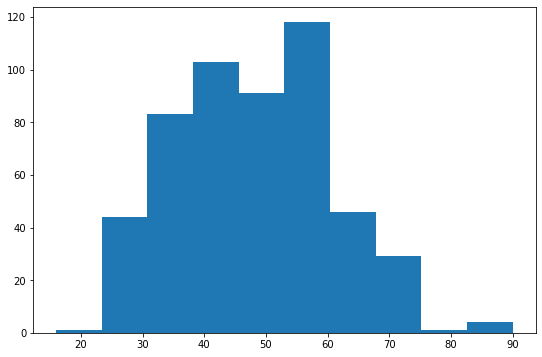

In [6]:
plt.rcParams["figure.figsize"] = (9, 6)
plt.hist(df['Age'])
plt.show()

###### Plotting number of instances of each target class

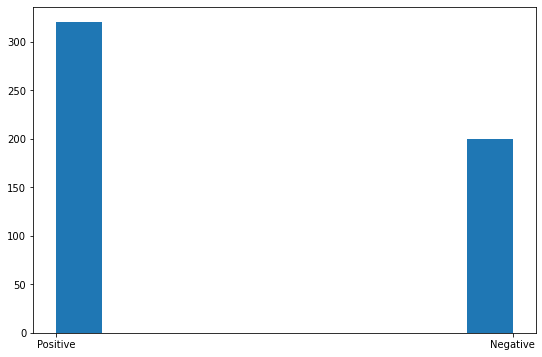

In [7]:
plt.hist(df['diabetic'])
plt.show()

###### Plotting instances for each categorical variable

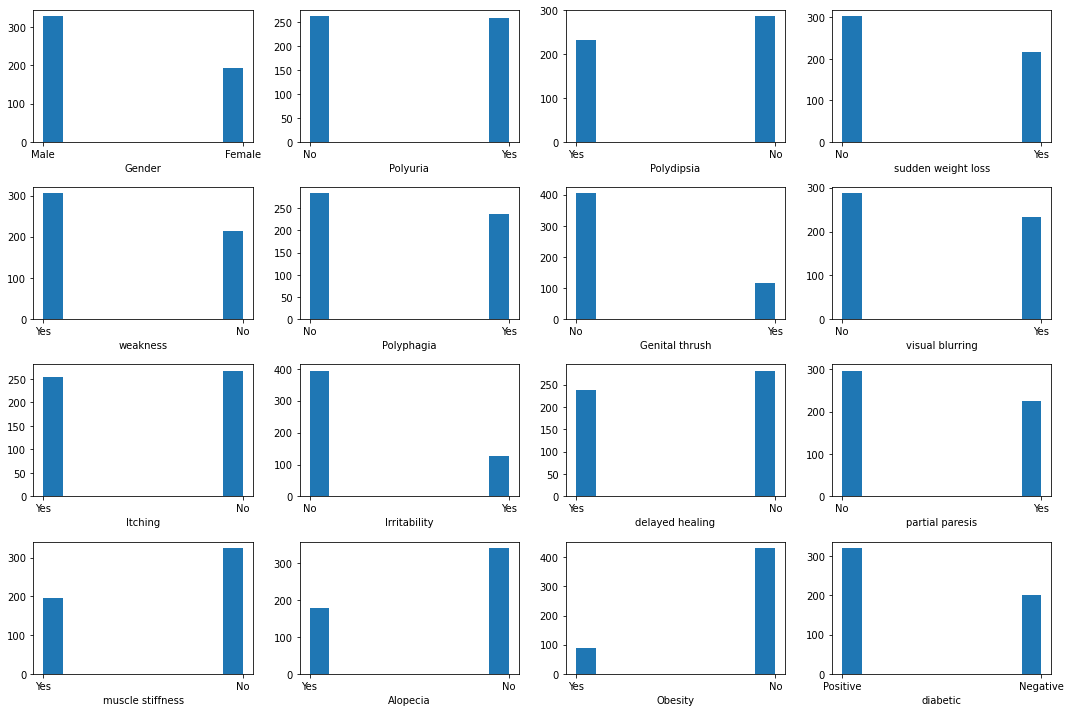

In [8]:
plt.rcParams["figure.figsize"] = (15, 10)
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(4, 4)
i, j = 0, 0
for col in df.columns:
    if 'int' not in str(df[col].dtype):
        ax = fig.add_subplot(gs[i, j])
        ax.hist(df[col])
        ax.set_xlabel(col)
        if j == 3:
            j = 0
            i = i + 1
        else:
            j = j + 1
plt.show()

###### Columns other than "Age" are categorical variables

In [9]:
categorical_variables = [col for col in df.columns
                         if col != 'Age' ]

###### Creating dummy encoding for all the categorical variables

In [10]:
df = pd.concat([df, pd.get_dummies(df[categorical_variables])], axis = 1)

###### Dropping original categorical columns

In [11]:
df.drop([col for col in df.columns if col in categorical_variables ], inplace = True, axis = 1)

###### Removing extra columns as follows:
1. Male Gender column (Gender 1 if female, 0 if male)
2. Columns with "no" in their name
3. Diabetic column having "negative" in name

In [12]:
df.drop([col for col in df.columns if '_' in col and 
         col[col.index('_') + 1:].lower() not in ['yes', 'female', 'positive']], 
        inplace = True, axis = 1)

###### Renaming new column names to original column names

In [13]:
df.columns = [col[:col.index('_')] if '_' in col else col for col in df.columns]

In [14]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,diabetic
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


###### Normalizing age

In [15]:
df['Age'] = df['Age']/100

In [16]:
figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1200x960 with 0 Axes>

<Figure size 1200x960 with 0 Axes>

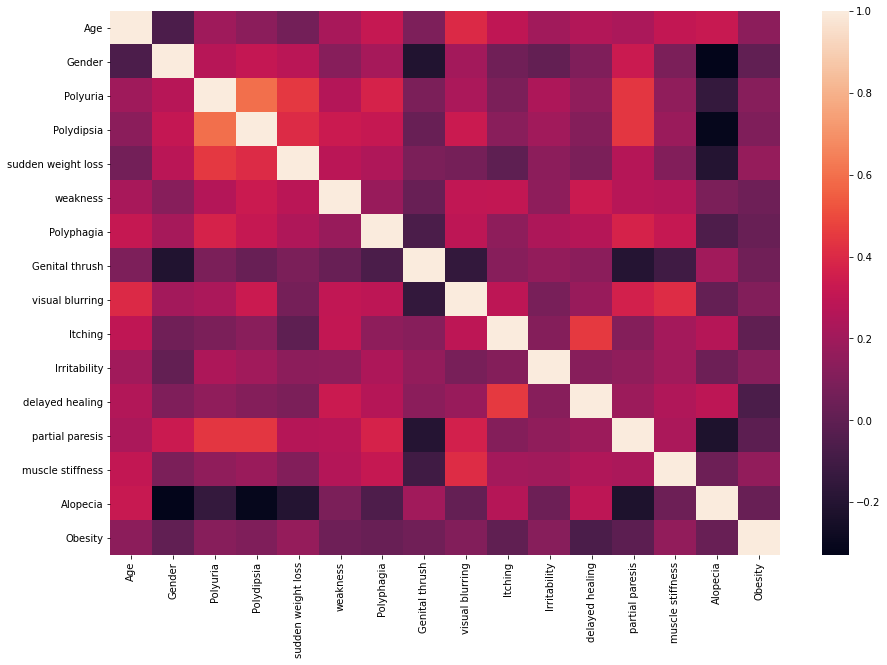

In [17]:
sns.heatmap(df[[col for col in df.columns if col != 'diabetic']].corr())

###### Checking for correlations greater than 0.7

In [18]:
df.corr().stack()[(df.corr().stack() > 0.7) & (df.corr().stack() != 1)]

Series([], dtype: float64)

###### Checking for correlation less than -0.5

In [19]:
df.corr().stack()[df.corr().stack() < -0.5]

Series([], dtype: float64)

###### Checking number of intances of each outcome

In [20]:
df['diabetic'].value_counts()

1    320
0    200
Name: diabetic, dtype: int64

###### Creating a function to print Confusion Matrix, Precision, Recall and F1-score

In [21]:
def print_results(method, true_value, predicted_value):
    
    """
    Method to print results of classification models
    
    Input: 
        
        method (str): Name of the classification method
        
        true_value (pandas.core.series.Series): Actual values of the target
        
        predicted_values (pandas.core.series.Series): Predicted values of the target
        
    """
    
    print(f"Classification Algorithm: {method}", end = "\n\n")
    
    print('Confusion Matrix')
    print(confusion_matrix(true_value, predicted_value), end = "\n\n")
    
    print("Precision")
    print(round(precision_score(true_value, predicted_value), 4), end = "\n\n")
    
    print("Recall")
    print(round(recall_score(true_value, predicted_value), 4), end = "\n\n")
    
    print("F1-Score")
    print(round(f1_score(true_value, predicted_value), 4))

###### Dividing data into train and test using stratified sampling

In [22]:
X = df[[col for col in df.columns if col != 'diabetic']]
y = df['diabetic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

### Logistic Regression

In [23]:
# Logistic Regression Model
lrc = LogisticRegression(random_state = 0, 
                         multi_class = 'ovr', 
                         penalty = 'elasticnet', 
                         solver = 'saga')

# Grid Search model for logistic regression
lrc_cv = GridSearchCV(lrc, param_grid = 
                      {'l1_ratio': [round(x * 0.1, 1) 
                                   for x in range(0, 11)]}, 
                     cv = 7)

# Fitting model
lrc_cv.fit(X_train, y_train)

# Making predictions
lr_predictions  = lrc_cv.predict(X_test)

# Printing Results
print_results("Logistic Regression", y_test, lr_predictions)

Classification Algorithm: Logistic Regression

Confusion Matrix
[[56  4]
 [ 9 87]]

Precision
0.956

Recall
0.9062

F1-Score
0.9305


### Support Vector Machine Classification

In [24]:
svmc = svm.SVC(degree = 5)
svmc_cv = GridSearchCV(svmc, 
                       param_grid = {'kernel': 
                                     ['linear', 'poly', 
                                      'rbf', 'sigmoid'], 
                                     'degree': [2, 3, 4, 5, 6]}, 
                       cv = 7)
svmc_cv.fit(X_train, y_train)
svm_predictions = svmc_cv.predict(X_test)
print_results("Support Vector Machine", y_test, svm_predictions)

Classification Algorithm: Support Vector Machine

Confusion Matrix
[[58  2]
 [ 4 92]]

Precision
0.9787

Recall
0.9583

F1-Score
0.9684


### K - Nearest Neighbors

In [25]:
knnc = KNeighborsClassifier()
knnc_cv = GridSearchCV(knnc, 
                       param_grid = {'n_neighbors': [i for i in range(3, 17)],  
                                     'p': [i for i in range(1, 5)]}, 
                       cv = 7)
knnc_cv.fit(X_train, y_train)
knn_predictions = knnc_cv.predict(X_test)
print_results("KNN", y_test, knn_predictions)

Classification Algorithm: KNN

Confusion Matrix
[[59  1]
 [ 8 88]]

Precision
0.9888

Recall
0.9167

F1-Score
0.9514


### Random Forest Classification

In [26]:
rfc = RandomForestClassifier(random_state = 42)
rfc_cv = GridSearchCV(rfc, 
                      param_grid = {'criterion': ['gini', 'entropy']}, 
                      cv = 7)
rfc_cv.fit(X_train, y_train)
rfc_predictions = rfc_cv.predict(X_test)
print_results("Random Forest", y_test, rfc_predictions)

Classification Algorithm: Random Forest

Confusion Matrix
[[59  1]
 [ 1 95]]

Precision
0.9896

Recall
0.9896

F1-Score
0.9896


---
# Model Comparison
  
| Model | Precision | Recall | F1-Score |
| :- | -: | -: | -: |
| Logistic Regression | 0.956 | 0.9062 | 0.9305 |
| Support Vector Machine | 0.9787 | 0.9583 | 0.9684 |
| K-Nearest Neighbors | 0.9888 | 0.9167 | 0.9514 |
| Random Forest | 0.9896 | 0.9896 | 0.9896 |

- We observe that the best result is obtained when Random Forrest Classifier is used, with only 1 mis-classification per class.  
- If we compare the F1 scores, the next best model is the Support Vector Machine, followed by KNN.  
- The second-best precision is for KNN, followed by SVM.  
- The second-best recall is for SVM, followed by KNN.  